In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import struct
from array import array
from os.path  import join
import os
%matplotlib inline
import random
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

In [41]:
#Gaussian Kernel
sigma = 1**0;
def k4v(x,y):
    numxPoints = np.shape(x)[0];
    numyPoints = np.shape(y)[0];
    XminusYSquared =np.sum(x*x,axis=1).reshape([numxPoints,1])-2*np.dot(x,y.T)+np.sum(y*y,axis=1).reshape([1,numyPoints]);
    return np.exp(-XminusYSquared/(2*sigma**2))
def k5v(x,y):
    return np.dot(x,y.T)

In [42]:
#Step 1: Generate Equally Space l
# return an array of lambda values
def generate_l (start,end,m):
    l = np.zeros(m)
    l[0] = start
    increase = (end-start)/(m-1)
    for i in range (1,m):
        l[i] = start + increase*i
    return l

In [43]:
#Initialize v according to StraifieldKFold size split
# return a list of arrays for each v
def initialize_v (m,X,y):
    v = np.zeros(m)
    stratified_kfold = StratifiedKFold(n_splits=m, shuffle=True, random_state=42)
    return stratified_kfold, v

In [66]:
def cross_validation_ridge_regression_algorithm(start_l,end_l,m,X_train,y_train):

    #Initialize l
    l = generate_l (start_l,end_l,m)

    #Split data and create v for each cross validation set
    stratified_kfold, v = initialize_v (m,X_train,y_train)

    for train_index, test_index in stratified_kfold.split(X_train, y_train):
        X_D_j, X_j = X_train[train_index], X_train[test_index]
        y_D_j, y_j = y_train[train_index], y_train[test_index]

        #Calculute matrix K and decomposition
        K = k5v(X_D_j,X_D_j)

        for i in range (m):
            # Calculate alpha
            alpha = calculate_alpha(K,y_D_j,l[i])

            #calculate f^*
            f  = calculate_f(X_j,X_D_j,alpha)

            temp = (f - y_j)**2
            temp = np.sum(temp)
            v[i] += temp
    return v,l

def decomposition(K):
    eigenvalues, U= np.linalg.eigh(K)
    A = np.diag(eigenvalues)
    return A,U

def calculate_alpha(K,y_D_j,l):
    A,U = decomposition(K)
    n = y_D_j.shape[0]
    temp = A + n * l * np.eye(A.shape[0])
    temp = np.linalg.inv(temp)
    alpha = U @ temp @ U.T @ y_D_j
    return alpha
def calculate_f(X_train,X_test,alpha):
    k_temp = k5v(X_train,X_test)
    result_matrix = k_temp * alpha[:, np.newaxis].T
    f  = np.sum(result_matrix, axis=1)
    return f

In [67]:
def ridge_regression (start_l,end_l,m,X_train,y_train,X_test):

    #determine optimal l using ridge regression
    v,l = cross_validation_ridge_regression_algorithm(start_l,end_l,m,X_train,y_train)
    plt.plot(l,v)
    plt.xlabel("lambda value")
    plt.ylabel("Error")
    smallest_index = np.argmin(v)
    optimal_l = l[smallest_index]
    #calculate optimal alpha
    K = k5v(X_train,X_train)
    alpha = calculate_alpha(K,y_train,optimal_l)

    #test final function
    f = calculate_f(X_test,X_train,alpha)
    return optimal_l, f

In [68]:
# iris specific to determine errors
def replace_elements(arr, value1, value2, error_value='error'):
    result = np.empty_like(arr, dtype=object)

    for index, element in np.ndenumerate(arr):
        if np.abs(element - value1) < np.abs(element - value2):
            result[index] = value1
        elif np.abs(element - value2) < np.abs(element - value1):
            result[index] = value2
        else:
            result[index] = error_value

    return result

In [33]:
#Using Iris Dataset
iris = load_iris()
# target value 0: I.setosa, 1: versicolor 2: virginica
split_ratio = 0.8

#Build a classifier for setosa and versicolor
#Only select data from the 0 and 1
X = iris.data[(iris.target==0) | (iris.target ==1)]
y = iris.target[(iris.target==0) | (iris.target ==1)]
#Split data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 1-split_ratio)
#Calc size
n = X_train.shape[0]

In [ ]:
#Intepretation of result
optimal_l,f = ridge_regression (0,0.5,10,X_train,y_train,X_test)
f = replace_elements(f, 0, 1, error_value='error')
error = np.count_nonzero(f-y_test)/y_test.size *100
print(f"Error is {error}% with optimal l being {optimal_l}" )

In [ ]:
#if randomly select
l = [i*0.1 for i in range (10)]
print(l)
for i in range (len(l)):
    #calculate optimal alpha
    K = k5v(X_train,X_train)
    alpha = calculate_alpha(K,y_train,l[i])

    #test final function
    f = calculate_f(X_test,X_train,alpha)
    f = replace_elements(f, 0, 1, error_value='error')
    error = np.count_nonzero(f-y_test)/y_test.size *100
    print(f"Error is {error} for lambda term = {l[i]}")

In [ ]:
#Testing for MNIST data set

In [69]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [70]:
input_path = '../Stat_Learning'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path,'t10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

#
# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array (y_test)

In [71]:
# Gathering data for specific numbers
def select_classification (a, b,x_train,x_test,y_train,y_test):
    selected_indices = np.where((y_train == a) | (y_train == b))
    x_train = x_train[selected_indices]
    y_train = y_train[selected_indices]
    selected_indices = np.where((y_test == a) | (y_test == b))
    x_test = x_test[selected_indices]
    y_test = y_test[selected_indices]
    return x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test = select_classification (0, 1,x_train,x_test,y_train,y_test)

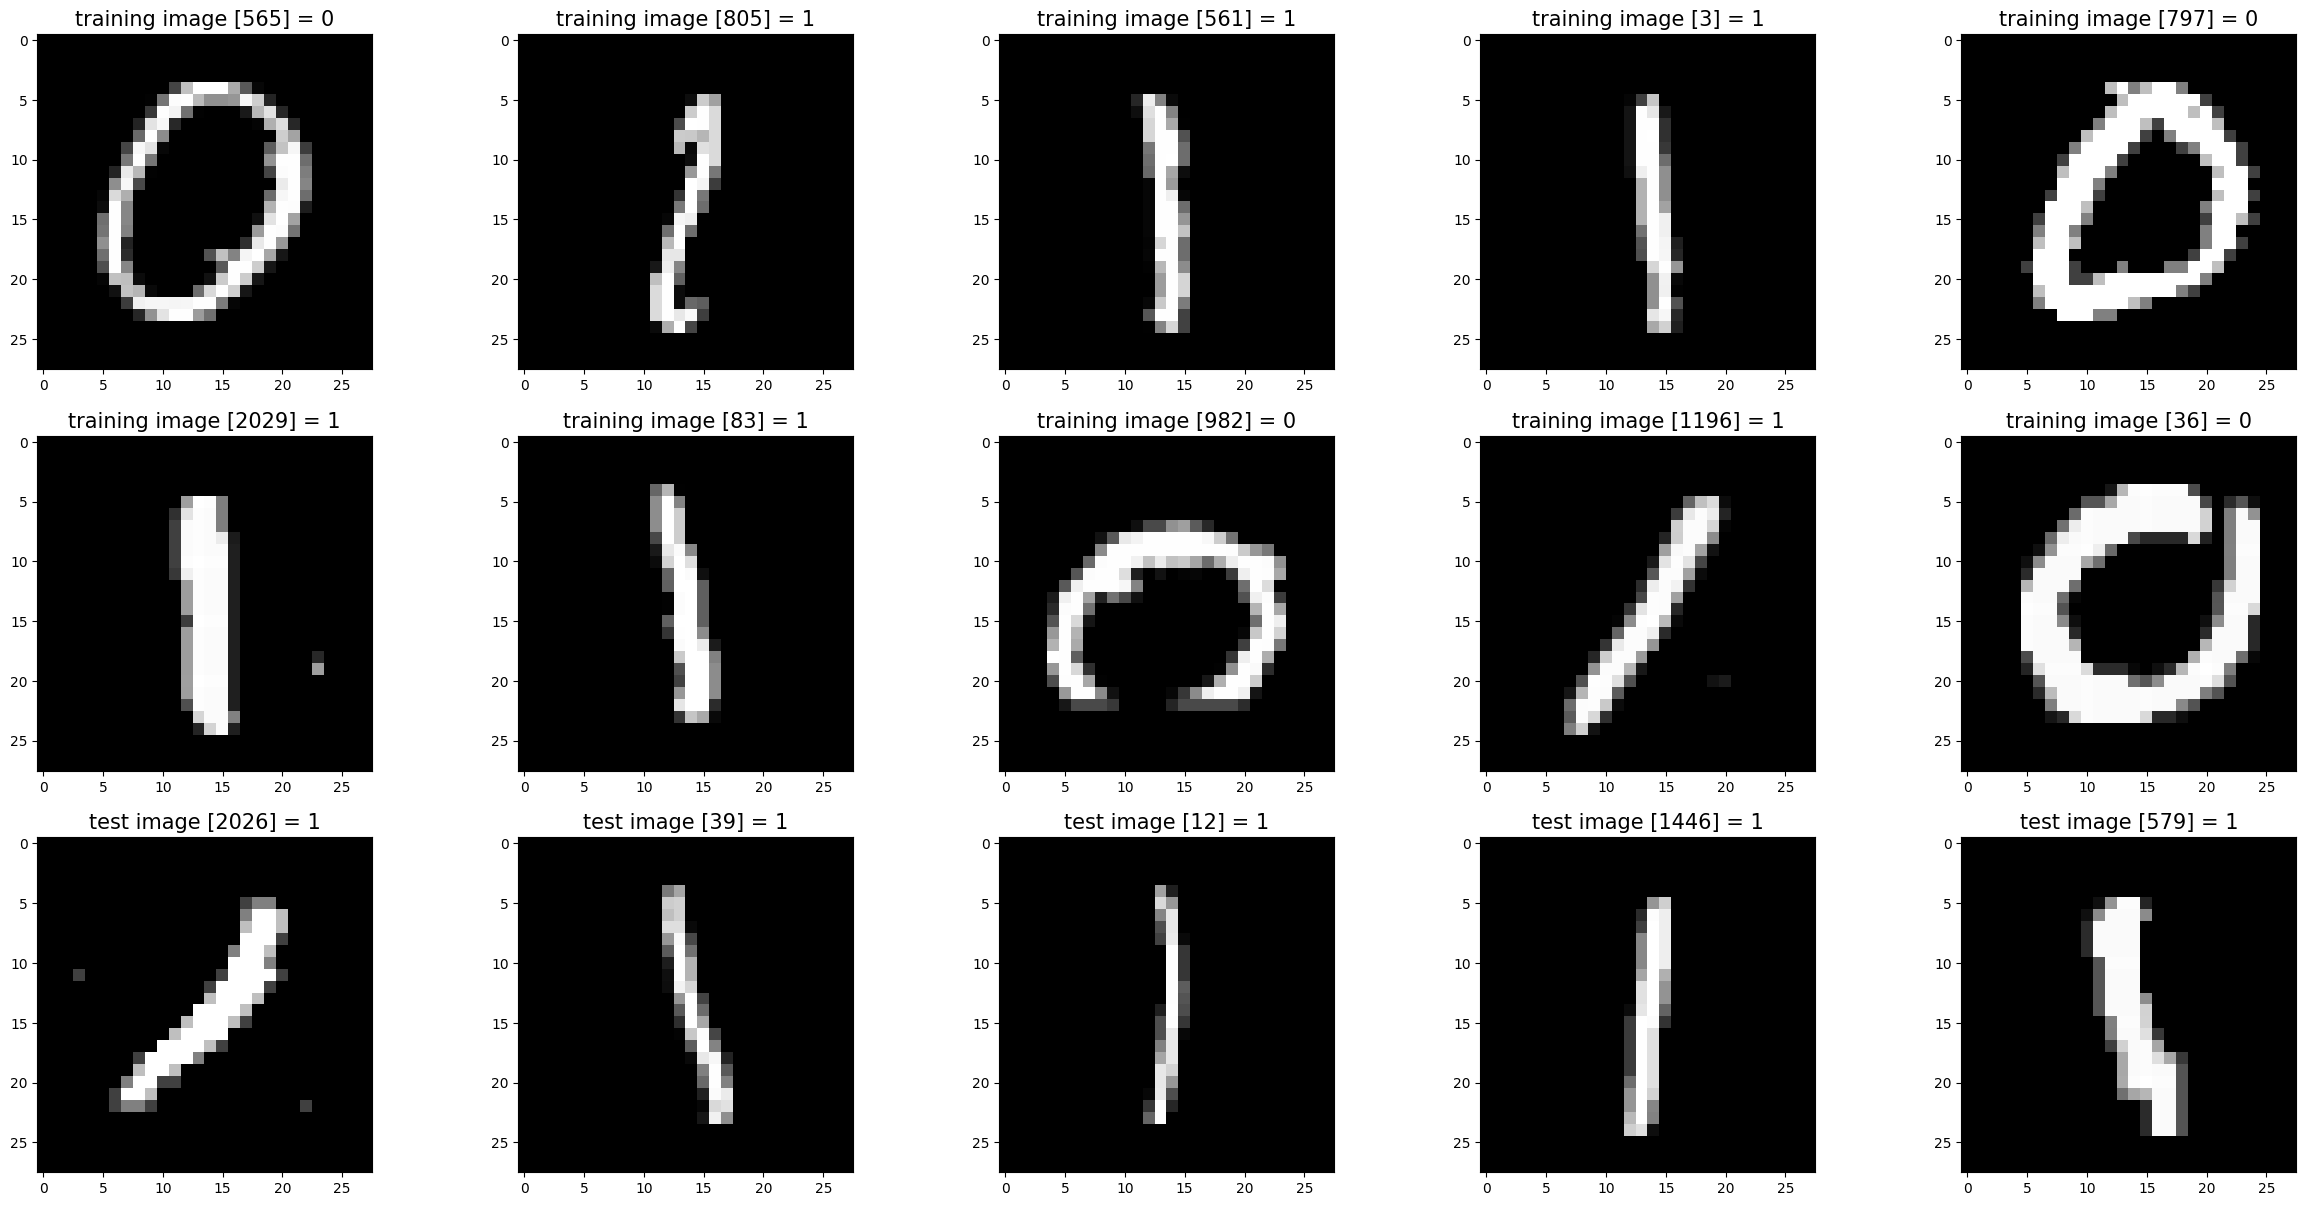

In [72]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 2115)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 2115)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [77]:
x_train, _, y_train, _ = train_test_split(x_train,y_train,test_size = 1-0.3,random_state = 23)
x_test, _, y_test, _ = train_test_split(x_test,y_test,test_size = 1-0.4,random_state = 23)
print(x_train.shape,x_test.shape[0])

(1139, 784) 338


In [78]:
#x_train_resized = np.array([zoom(graph, (3/28, 3/28), order=3) for graph in x_train])
#x_test_resized = np.array([zoom(graph, (3/28, 3/28), order=3) for graph in x_test])

In [79]:
#Flatten the image
x_train = x_train.reshape((x_train.shape[0], 28*28))
x_test = x_test.reshape((x_test.shape[0], 28*28))

[-1.61864649e+01 -5.01484246e+00 -3.00365110e+01  2.23533695e+01
  4.05167535e+00 -9.40928761e+00 -1.25884775e+01 -5.26599803e-01
  7.28732942e+00 -9.34204257e+00  7.11488768e+00 -4.06068076e+00
 -1.18965332e+01 -6.68410924e+00  1.70326358e+01 -1.40463029e+00
  5.39428554e+00 -1.08840227e+00 -1.25187118e+01 -2.82853086e+01
  1.49489398e+01 -9.45775808e-01  5.58288900e+00  5.94283252e+00
 -5.94935016e+00  1.04803097e+01 -4.58057076e+00  3.05066935e-01
 -7.49345390e+00 -1.06075517e+01  8.51221428e+00 -1.32884931e+01
 -1.04514377e+01  1.44129967e+01  1.63218952e+01  3.62600190e+00
 -3.19974536e+00 -1.53365159e+01 -1.06244191e+01  9.08673333e+00
  5.75311568e+00  4.67592865e+00  1.06474590e+01  4.36994796e+00
 -2.18429832e+01  2.85010218e+01 -1.67651856e+01  1.60285341e+01
  6.93057979e+00  2.82891038e-01  7.28267109e+00 -9.36815731e+00
 -1.25442129e+01 -6.42855952e+00 -9.44617195e+00  8.81088843e+00
 -3.22734270e+00 -1.58531298e+01  1.35190145e+01 -4.55625812e+00
  4.07171725e+00 -5.21020

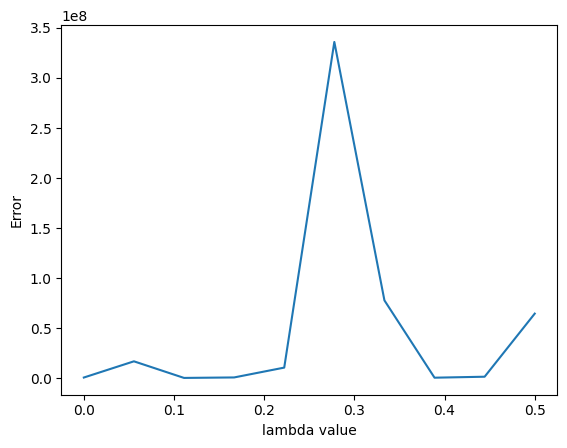

In [80]:
optimal_l,f = ridge_regression (0,0.5,10,x_train,y_train,x_test)
print(f,optimal_l)

In [81]:
f = replace_elements(f, 0, 1, error_value='error')
error = np.count_nonzero(f-y_test)/y_test.size *100
print(f"Error is {error}% with optimal l being {optimal_l}" )

Error is 47.337278106508876% with optimal l being 0.1111111111111111


In [62]:
l = [i*0.1 for i in range (10)]
print(l)
for i in range (len(l)):
    #calculate optimal alpha
    K = k5v(x_train,x_train)
    alpha = calculate_alpha(K,y_train,l[i])

    #test final function
    f = calculate_f(x_test,x_train,alpha)
    f = replace_elements(f, 0, 1, error_value='error')
    error = np.count_nonzero(f-y_test)/y_test.size *100
    print(f"Error is {error} for lambda term = {l[i]}")

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9]
[ -5738.88672131  -5710.83637659  -5631.45829222 ...   5663.38501163
   5731.77092508 193815.49891166]
Error is 40.828402366863905 for lambda term = 0.0
[ -5738.88672131  -5710.83637659  -5631.45829222 ...   5663.38501163
   5731.77092508 193815.49891166]
Error is 47.0414201183432 for lambda term = 0.1
[ -5738.88672131  -5710.83637659  -5631.45829222 ...   5663.38501163
   5731.77092508 193815.49891166]
Error is 50.0 for lambda term = 0.2
[ -5738.88672131  -5710.83637659  -5631.45829222 ...   5663.38501163
   5731.77092508 193815.49891166]
Error is 54.142011834319526 for lambda term = 0.30000000000000004
[ -5738.88672131  -5710.83637659  -5631.45829222 ...   5663.38501163
   5731.77092508 193815.49891166]
Error is 55.02958579881657 for lambda term = 0.4
[ -5738.88672131  -5710.83637659  -5631.45829222 ...   5663.38501163
   5731.77092508 193815.49891166]
Error is 50.29585798816568 for lambd